## Example 06 - Container Transfer Hub

**Example description:** Example of a container transfer hub, where very large container vessels deliver containers, while smaller vessels take care of the distribution to the hinterland.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [262]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx

In [263]:
# Create simulation environment
simulation_start = datetime.datetime(2019, 1, 1)

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions

#### Create objects and specify the properties for sites you wish to create

In [264]:
def connect_sites_with_path(data_from_site, data_to_site, data_node, path):
    Nodes = []
    Edges = []
    Site = type('Site', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable,    # Add coordinates to extract distance information and visualize
             core.HasContainer, # Add information on the material available at the site
             core.HasResource), # Add information on serving equipment
    {})                         # The dictionary is empty because the site type is generic

    Node = type('Node', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable),   # Add coordinates to extract distance information and visualize
    {})                         # The dictionary is empty because the site type is generic

    for i, j in enumerate(path):
        if i == 0:
            data_from_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_from_site))

        elif i == len(path) - 1:
            data_to_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_to_site))
            Edges.append([Nodes[i-1], Nodes[i]])
            
        else:
            data_node["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            data_node["name"]='node-' + str(i)
            node = Node(**data_node)
            node.name = node.id
            Nodes.append(node)
            Edges.append([Nodes[i-1], Nodes[i]])
            
    return Nodes, Edges

In [265]:
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Origin locatie",       # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": 10_000_000,         # The capacity of the site
                  "level": 10_000_000}            # The actual volume of the site

data_inter_site = {"env": my_env,                 # The simpy environment defined in the first cel
                "name": "Overslag locatie",       # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 10_000_000,           # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site1 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Nijmegen",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site2 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Deventer",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_node = {"env": my_env,                       # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the site
                 "geometry": []}                  # The coordinates of the project site


In [266]:
 path_from_to_inter = [[0.4961956247618216,51.50367589686757],
                        [0.5025738662738322,51.49604982804586],
                        [4.064841994596411,51.94963274522105],
                        [4.067560378249368,51.95173269362142]]

In [267]:
path_inter_to_destination1 = [[4.067560378249368,51.95173269362142],
                             [4.076820637063388,51.95330987222201],
                             [4.079712688631274,51.953446219582],
                             [5.260911,51.820500],
                             [5.830619709457634,51.86183419049677],
                             [5.830727947258836,51.86102575658615]]

In [268]:
path_inter_to_destination2 = [[4.067560378249368,51.95173269362142],
                             [4.076820637063388,51.95330987222201],
                             [4.079712688631274,51.953446219582],
                             [5.937599,51.964640],
                             [6.197050,52.092425],
                             [6.172119444444445,52.247375]]

#### Finally create specific instances of the predefined objects with the specified properties

In [269]:
Nodes1, Edges1 = connect_sites_with_path(data_from_site, data_inter_site, data_node, path_from_to_inter)
Nodes2, Edges2 = connect_sites_with_path(data_inter_site, data_to_site1, data_node, path_inter_to_destination1)
Nodes3, Edges3 = connect_sites_with_path(data_inter_site, data_to_site2, data_node, path_inter_to_destination2)

#### Create graph

Origin locatie
643d8101-628e-11e9-8c82-60f677ba2ce0
643d8102-628e-11e9-8d54-60f677ba2ce0
Overslag locatie
Origin locatie - 643d8101-628e-11e9-8c82-60f677ba2ce0
643d8101-628e-11e9-8c82-60f677ba2ce0 - 643d8102-628e-11e9-8d54-60f677ba2ce0
643d8102-628e-11e9-8d54-60f677ba2ce0 - Overslag locatie
Overslag locatie
643da80b-628e-11e9-91ad-60f677ba2ce0
643da80c-628e-11e9-b1ed-60f677ba2ce0
643da80d-628e-11e9-abcb-60f677ba2ce0
643da80e-628e-11e9-9ac4-60f677ba2ce0
Haven Nijmegen
Overslag locatie - 643da80b-628e-11e9-91ad-60f677ba2ce0
643da80b-628e-11e9-91ad-60f677ba2ce0 - 643da80c-628e-11e9-b1ed-60f677ba2ce0
643da80c-628e-11e9-b1ed-60f677ba2ce0 - 643da80d-628e-11e9-abcb-60f677ba2ce0
643da80d-628e-11e9-abcb-60f677ba2ce0 - 643da80e-628e-11e9-9ac4-60f677ba2ce0
643da80e-628e-11e9-9ac4-60f677ba2ce0 - Haven Nijmegen
Overslag locatie
643dcf2f-628e-11e9-b16c-60f677ba2ce0
643dcf30-628e-11e9-8c37-60f677ba2ce0
643dcf31-628e-11e9-85e3-60f677ba2ce0
643dcf32-628e-11e9-a0ee-60f677ba2ce0
Haven Deventer
Overslag l

c:\users\mrv\appdata\local\continuum\miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



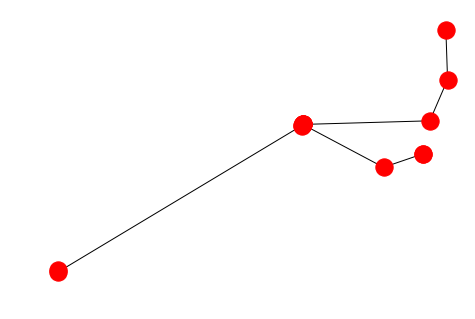

In [270]:
def add_path_to_graph(FG, positions, Nodes, Edges):
    
    for node in Nodes:
        print(node.name)
        positions[node.name] = (node.geometry.x, node.geometry.y)
        FG.add_node(node.name, geometry = node.geometry)

    for edge in Edges:
        print(edge[0].name + ' - ' + edge[1].name)
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)

    return FG, positions

positions = {}
FG = nx.Graph()

FG, positions = add_path_to_graph(FG, positions, Nodes1, Edges1)
FG, positions = add_path_to_graph(FG, positions, Nodes2, Edges2)
FG, positions = add_path_to_graph(FG, positions, Nodes3, Edges3)

nx.draw(FG, positions)

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - A moving container, so capacity and location
    core.Processor - Allow for loading and unloading
    core.HasResource - Add information on serving equipment
    core.HasDepthRestriction - Add information on depth restriction 

#### First create objects with the desired properties

In [271]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.HasSoil,                   # Add soil object, because it moves soil
                                    core.Routeable),                # Initialize spill terms
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [272]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda current_level, desired_level: (desired_level - current_level) / rate

def compute_unloading(rate):
    return lambda current_level, desired_level: (current_level - desired_level) / rate

In [273]:
# Large container vessel variables
data_container_large = {"env": my_env,                              # The simpy environment 
               "name": "Container large",                           # Name
               "geometry": Nodes1[0].geometry,                      # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 20_000,                                  # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed 

In [274]:
# Small container vessel variables
data_container_small_01 = {"env": my_env,                             # The simpy environment 
               "name": "Container small_01",                           # Name
               "geometry": Nodes1[-1].geometry,                      # It starts at the "inter site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed

In [275]:
# Small container vessel variables
data_container_small_02 = {"env": my_env,                             # The simpy environment 
               "name": "Container small_02",                           # Name
               "geometry": Nodes1[-1].geometry,                      # It starts at the "inter site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed

#### Finally create specific instances of the predefined objects with the specified properties

In [276]:
# The simulation object
container_large = TransportProcessingResource(**data_container_large)
container_small_01 = TransportProcessingResource(**data_container_small_01)
container_small_02 = TransportProcessingResource(**data_container_small_02)

### 1.3 Define the activity

In [277]:
# # conditie dat intermediate niet leeg is
# condition = model.LevelCondition(container=intermediate.container, min_level=1)  

# # conditie dat een jaar verstreken is
# stop_condition = modelTimeCondition(…)  
 
# activity_2 = model.Activity(…, 
# start_condition = None,  # laat de activiteit meteen starten als de simulatie begint
#                         condition = condition,  # steeds als tussendoor de intermediate container leeg is, wacht een uur en check daarna nog eens
#                         stop_condition = stop_condition)  # de activiteit eindigt als een jaar verstreken is
# (idem voor activity_3)


In [278]:
# Continuous simulation, stop after one year
stop_condition_1 = model.TimeCondition(my_env, start = datetime.datetime(2019, 1, 1), stop = datetime.datetime(2019, 3, 1))
stop_condition_2 = model.TimeCondition(my_env, start = datetime.datetime(2019, 1, 1), stop = datetime.datetime(2020, 1, 1)) 
condition = model.LevelCondition(container=Nodes1[-1], min_level=1)

In [279]:
# Create activity
activity_1 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "International transport", # We are moving soil
                          origin = Nodes1[0],               # We originate from the from_site
                          destination = Nodes1[-1],         # And therefore travel to the to_site
                          loader = container_large,         # The benefit of a TSHD, all steps can be done
                          mover = container_large,          # The benefit of a TSHD, all steps can be done
                          unloader = container_large,       # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          stop_condition = stop_condition_1)            # stop after 1 year simulation

In [280]:
# Create activity                      
activity_2 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Nijmegen",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes2[-1],         # And therefore travel to the to_site
                          loader = container_small_01,         # The benefit of a TSHD, all steps can be done
                          mover = container_small_01,          # The benefit of a TSHD, all steps can be done
                          unloader = container_small_01,       # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition,
                          stop_condition = stop_condition_2)            # We stop when the capacity is full

In [281]:
# Create activity                      
activity_3 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Deventer",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes3[-1],         # And therefore travel to the to_site
                          loader = container_small_02,         # The benefit of a TSHD, all steps can be done
                          mover = container_small_02,          # The benefit of a TSHD, all steps can be done
                          unloader = container_small_02,       # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition,
                          stop_condition = stop_condition_2)            # We stop when the capacity is full

### 2. Run the simulation

In [282]:
my_env.FG = FG
my_env.run()

print("\n*** Transportation of containers finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))


Time = 2019-01-01 00:00
Start condition is satisfied, International transport transporting from Origin locatie to Overslag locatie started.

Time = 2019-01-01 00:00
Start condition is satisfied, Hinterland transport Nijmegen transporting from Overslag locatie to Haven Nijmegen started.

Time = 2019-01-01 00:00
Start condition is satisfied, Hinterland transport Deventer transporting from Overslag locatie to Haven Deventer started.

Time = 2019-03-01 15:24
Stop condition is satisfied, International transport transporting from Origin locatie to Overslag locatie completed.

Time = 2020-01-01 00:27
Stop condition is satisfied, Hinterland transport Deventer transporting from Overslag locatie to Haven Deventer completed.

Time = 2020-01-01 00:50
Stop condition is satisfied, Hinterland transport Nijmegen transporting from Overslag locatie to Haven Nijmegen completed.

*** Transportation of containers finished in 365 days, 0:50:38 ***


### 3. Postprocessing

In [283]:
vessels = [container_large, container_small_01, container_small_02]
print(vessels)

import pandas as pd
df = pd.DataFrame.from_dict(vessels[0].log)
df

[<__main__.TransportProcessingResource object at 0x0000020DAED44400>, <__main__.TransportProcessingResource object at 0x0000020DAED44A58>, <__main__.TransportProcessingResource object at 0x0000020DAED449E8>]


,Message,Timestamp,Value,Geometry
0,loading start,2019-01-01 00:00:00.000000,0.0,POINT (0.4961956247618216 51.50367589686757)
1,loading stop,2019-01-01 03:42:13.333333,20000.0,POINT (0.4961956247618216 51.50367589686757)
2,sailing filled start,2019-01-01 03:42:13.333333,20000.0,POINT (0.4961956247618216 51.50367589686757)
3,Sailing,2019-01-01 03:45:46.023704,0.0,POINT (0.5025738662738322 51.49604982804586)
4,Sailing,2019-01-01 19:16:19.336763,0.0,POINT (4.064841994596411 51.94963274522105)
5,Sailing,2019-01-01 19:17:25.827284,0.0,POINT (4.067560378249368 51.95173269362142)
6,sailing filled stop,2019-01-01 19:17:25.827284,20000.0,POINT (4.067560378249368 51.95173269362142)
7,unloading start,2019-01-01 19:17:25.827284,20000.0,POINT (4.067560378249368 51.95173269362142)
8,unloading stop,2019-01-01 22:59:39.160617,0.0,POINT (4.067560378249368 51.95173269362142)
9,sailing empty start,2019-01-01 22:59:39.160617,0.0,POINT (4.067560378249368 51.95173269362142)


#### Vessel planning

In [284]:
activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### KML visualisation

In [285]:
plot.vessel_kml(my_env, vessels, stepsize = 10000)

In [286]:
plot.site_kml(my_env, [Nodes1[0], Nodes1[-1], Nodes2[-1], Nodes3[-1]], stepsize = 10000)

In [287]:
# open the file
if platform.system():
    !start ./vessel_movements.kml
    !start ./site_development.kml
else:
    !start explorer ./vessel_movements.kml
    !start explorer ./site_development.kml